In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ACTION_SPACE = ('U', 'D', 'L', 'R')
class gridWorld:
    
    def __init__(self,rows,cols,startPosition):
        self.rows = rows
        self.cols = cols
        self.i = startPosition[0]
        self.j = startPosition[1]
        
    
    def setOnGrid(self,rewards,actions):
        self.rewards = rewards
        self.actions = actions
    
    def setState(self,s):
        self.i = s[0]
        self.j = s[1]
    
    def move(self,a):
        if a in self.actions[self.i,self.j] :
            if a =='U':
                self.i -= 1
            elif a =='D':
                self.i += 1
            elif a == 'L':
                self.j -= 1
            elif a == 'R':
                self.j += 1
        return self.rewards.get((self.i,self.j),0)
    
    def getNextState(self,s,a):
        i,j = s[0],s[1]
        
        if a in self.actions[(i,j)]:
            if a =='U':
                i -= 1
            elif a =='D':
                i += 1
            elif a == 'L':
                j -= 1
            elif a == 'R':
                j += 1
        return i,j
                
    def allStates(self):
        return set(self.actions.keys()) | set(self.rewards.keys())
        
    def allActions(self):
        return np.array(['U','D','L','R'])
    
    def currentState(self):
        return (self.i,self.j)
    
    def isTerminal(self,s):
        return s not in self.actions
    
    def reset(self):
        self.i = 2
        self.j = 0
        return (self.i,self.j)
    
    def gameOver(self):
        return (self.i, self.j) not in self.actions
            
    
def standardGrid():
    g = gridWorld(2+1,3+1,(2,0))
    rewards = {(0,3): +1 ,(1,3): -1}
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('L', 'R', 'U'),
        (2, 3): ('L', 'U'),
    }
    g.setOnGrid(rewards,actions)
    return g

def negativeGrid():
    g = standardGrid()
    g.rewards.update({
        (0, 0): step_cost,
        (0, 1): step_cost,
        (0, 2): step_cost,
        (1, 0): step_cost,
        (1, 2): step_cost,
        (2, 0): step_cost,
        (2, 1): step_cost,
        (2, 2): step_cost,
        (2, 3): step_cost,
    })
    return g

def printPolicy(P, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

def printValues(V, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print("")
        

In [3]:
def playGame(grid , policy , max_steps = 20):
    s = grid.reset()
    a = epsilon_greedy(policy,s)
    
    states = [s]
    actions = [a]
    rewards = [0]
    
    for _ in range(max_steps):
        r = grid.move(a)
        s = grid.currentState()

        rewards.append(r)
        states.append(s)
    
        if grid.gameOver():
            break
        else:
            a = epsilon_greedy(policy,s)
            actions.append(a)
    
    return states,actions,rewards


def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often

  # find max val
  max_val = max(d.values())

  # find keys corresponding to max val
  max_keys = [key for key, val in d.items() if val == max_val]

  ### slow version
  # max_keys = []
  # for key, val in d.items():
  #   if val == max_val:
  #     max_keys.append(key)

  return np.random.choice(max_keys), max_val

def epsilon_greedy(policy,s,eps = 0.1):
    if np.random.random() > 0.1:
        return policy[s]
    else:
        return np.random.choice(ACTION_SPACE)

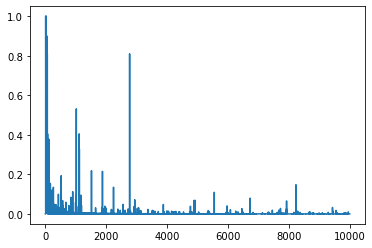

final policy:
---------------------------
  D  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |
final values:
---------------------------
 0.40| 0.89| 1.00| 0.00|
---------------------------
 0.50| 0.00| 0.89| 0.00|
---------------------------
 0.59| 0.66| 0.75| 0.64|
state_sample_count:
         0        1        2      3
0     12.0    275.0  10494.0    0.0
1    290.0      0.0  10515.0    0.0
2  10804.0  10750.0  10779.0  286.0


In [4]:
grid = standardGrid()
policy = {}
Q = {}
sample_counts = {}
state_sample_count = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ACTION_SPACE)
for s in grid.allStates():
    if s in grid.actions:
        Q[s] = {}
        sample_counts[s] = {}
        state_sample_count[s] = 0
        for a in ACTION_SPACE:
            Q[s][a] = 0
            sample_counts[s][a] = 0
    else:
        pass
#start_s = list(policy)[np.random.choice(len(policy))
gamma = 0.9
deltas = []
for _ in range(10000):
    delta = 0
    states,actions,rewards = playGame(grid,policy)
    
    states_actions = list(zip(states, actions))
    G = 0 
    T = len(states)
    for t in range(T-2,-1,-1):
        s = states[t]
        a = actions[t]
        G = rewards[t+1] + gamma * G
        if (s,a) not in  states_actions[:t]:
            old_q = Q[s][a]
            sample_counts[s][a] += 1
            lr = 1/sample_counts[s][a]
            Q[s][a] = old_q + lr * (G-old_q)
            #policy[s] = list(Q[s])[np.argmax(list(Q[s].values()))]
            policy[s] = max_dict(Q[s])[0]
            state_sample_count[s] += 1
            delta = max (delta,np.abs(old_q - Q[s][a]))
    deltas.append(delta)
plt.plot(deltas)
plt.show()
print("final policy:")
printPolicy(policy, grid)

  # find V
V = {}
for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

print("final values:")
printValues(V, grid)

print("state_sample_count:")
state_sample_count_arr = np.zeros((grid.rows, grid.cols))
for i in range(grid.rows):
    for j in range(grid.cols):
        if (i, j) in state_sample_count:
            state_sample_count_arr[i,j] = state_sample_count[(i, j)]
df = pd.DataFrame(state_sample_count_arr)
print(df)